# Hull Tactical Market Prediction - PyCaret Enhanced


## Step 1: Imports

In [5]:
import os
from pathlib import Path
import datetime
from typing import Optional, List, Callable, Tuple
import warnings

from tqdm import tqdm
from dataclasses import dataclass, asdict

import polars as pl 
import pandas as pd
import numpy as np
from scipy.stats import percentileofscore
from scipy.optimize import minimize
from sklearn.model_selection import TimeSeriesSplit

from pycaret.regression import (
    setup, 
    compare_models, 
    tune_model, 
    blend_models, 
    stack_models,
    create_model,
    predict_model,
    finalize_model,
    save_model,
    plot_model,
    pull
)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("✅ All imports successful!")


✅ All imports successful!


## Step 2: Configuration

In [6]:
# Paths
DATA_PATH: Path = Path('kaggle/input/hull-tactical-market-prediction/')

# Signal conversion parameters - IMPROVED
MIN_SIGNAL: float = 0.0
MAX_SIGNAL: float = 2.0
# Removed fixed multiplier - will be adaptive

# PyCaret configuration
RANDOM_SEED: int = 42
N_FOLDS: int = 10
TUNING_ITERATIONS: int = 15
TOP_N_MODELS: int = 6  # Increased for more diversity

# Feature engineering configuration - IMPROVED
ROLLING_WINDOWS: List[int] = [5, 10, 20]  # Shorter windows
LAG_PERIODS: List[int] = [1, 2, 3, 5]
EMBARGO_DAYS: int = 3  # Prevent leakage in CV

print(f"📋 Configuration:")
print(f"   📁 Data path: {DATA_PATH}")
print(f"   🎲 Random seed: {RANDOM_SEED}")
print(f"   🔄 CV folds: {N_FOLDS}")
print(f"   ⚙️ Tuning iterations: {TUNING_ITERATIONS}")
print(f"   📊 Rolling windows: {ROLLING_WINDOWS}")
print(f"   ⏮️ Lag periods: {LAG_PERIODS}")
print(f"   🚧 Embargo days: {EMBARGO_DAYS}")


📋 Configuration:
   📁 Data path: kaggle\input\hull-tactical-market-prediction
   🎲 Random seed: 42
   🔄 CV folds: 10
   ⚙️ Tuning iterations: 15
   📊 Rolling windows: [5, 10, 20]
   ⏮️ Lag periods: [1, 2, 3, 5]
   🚧 Embargo days: 3


## Step 3: Helper Classes

In [7]:
@dataclass(frozen=True)
class RetToSignalParameters:
    """Parameters for converting returns to trading signals"""
    prediction_std: float  # Adaptive based on data
    min_signal: float = MIN_SIGNAL
    max_signal: float = MAX_SIGNAL
    
    @property
    def signal_multiplier(self) -> float:
        """Calculate adaptive multiplier"""
        # Scale inversely with prediction std to use full range
        return 0.5 / (self.prediction_std + 1e-8)

print("✅ Parameters initialized")

✅ Parameters initialized


## Step 4: Data Loading & Feature Engineering



In [8]:
def load_trainset() -> pl.DataFrame:
    """Load and preprocess the training dataset."""
    return (
        pl.read_csv(DATA_PATH / "train.csv")
        .rename({'market_forward_excess_returns':'target'})
        .with_columns(
            pl.exclude('date_id').cast(pl.Float64, strict=False)
        )
        .head(-10)
    )


def load_testset() -> pl.DataFrame:
    """Load and preprocess the testing dataset."""
    return (
        pl.read_csv(DATA_PATH / "test.csv")
        .rename({'lagged_forward_returns':'target'})
        .with_columns(
            pl.exclude('date_id').cast(pl.Float64, strict=False)
        )
    )


def create_enhanced_dataset(df: pl.DataFrame, is_test: bool = False) -> pl.DataFrame:
    """
    Create ENHANCED features with proper time-series handling.
    IMPROVED: Prevents look-ahead bias with .shift()
    """
    had_is_test = "is_test" in df.columns

    base_features: List[str] = [
        "S2", "E2", "E3", "P9", "S1", "S5", "I2", "P8",
        "P10", "P12", "P13"
    ]
    
    # Create base features
    df = df.with_columns([
        (pl.col("I2") - pl.col("I1")).alias("U1"),
        (pl.col("M11") / ((pl.col("I2") + pl.col("I9") + pl.col("I7")) / 3 + 1e-8)).alias("U2")
    ])
    
    base_features.extend(["U1", "U2"])

    cols_to_select = ["date_id", "target"] + base_features
    if had_is_test:
        cols_to_select.append("is_test")
    df = df.select(cols_to_select)
    
    # Fill nulls
    df = df.with_columns([
        pl.col(col).fill_null(pl.col(col).ewm_mean(com=0.5))
        for col in base_features
    ])
    
    # Adjust windows based on data size
    if is_test or len(df) < 30:
        rolling_windows = [3, 5, 7]
        lag_periods = [1, 2, 3]
        roc_periods = [3, 5]
        print(f"   ⚠️  Using reduced windows (rows: {len(df)})")
    else:
        rolling_windows = ROLLING_WINDOWS
        lag_periods = LAG_PERIODS
        roc_periods = [5, 10]
    
    print("   🔧 Creating rolling features with proper time-series handling...")
    key_features = ["S2", "S5", "P8", "I2", "U1"]
    
    # IMPROVED: Use .shift(1) to prevent look-ahead bias
    for feat in key_features:
        for window in rolling_windows:
            df = df.with_columns([
                pl.col(feat).shift(1).rolling_mean(window).alias(f"{feat}_rmean_{window}"),
                pl.col(feat).shift(1).rolling_std(window).alias(f"{feat}_rstd_{window}"),
                pl.col(feat).shift(1).rolling_max(window).alias(f"{feat}_rmax_{window}"),
                pl.col(feat).shift(1).rolling_min(window).alias(f"{feat}_rmin_{window}"),
            ])
    
    print("   ⏮️ Creating lag features...")
    for feat in key_features:
        for lag in lag_periods:
            df = df.with_columns([
                pl.col(feat).shift(lag).alias(f"{feat}_lag_{lag}")
            ])
    
    print("   📈 Creating momentum features...")
    for feat in key_features:
        for period in roc_periods:
            df = df.with_columns([
                (pl.col(feat) - pl.col(feat).shift(period)).alias(f"{feat}_roc_{period}"),
                ((pl.col(feat) - pl.col(feat).shift(period)) / 
                 (pl.col(feat).shift(period).abs() + 1e-8)).alias(f"{feat}_pct_change_{period}")
            ])
    
    # IMPROVED: Add volatility regime features
    print("   🌡️ Creating regime features...")
    for feat in key_features:
        df = df.with_columns([
            (pl.col(feat).shift(1).rolling_std(20) > 
             pl.col(feat).shift(1).rolling_std(20).rolling_mean(60))
            .cast(pl.Int8).alias(f"{feat}_high_vol_regime")
        ])
    

    print("   🔗 Creating interaction features...")
    df = df.with_columns([
        (pl.col("S2") * pl.col("P8")).alias("S2_P8_interaction"),
        (pl.col("I2") / (pl.col("S5") + 1e-8)).alias("I2_S5_ratio"),
        (pl.col("U1") * pl.col("S2")).alias("U1_S2_interaction"),
    ])
    

    print("   📊 Creating RSI features...")
    for feat in ["S2", "I2"]:
        delta = pl.col(feat).diff()
        gain = delta.clip(lower_bound=0).shift(1).rolling_mean(14)
        loss = (-delta.clip(upper_bound=0)).shift(1).rolling_mean(14)
        rsi = 100 - (100 / (1 + gain / (loss + 1e-8)))
        df = df.with_columns([rsi.alias(f"{feat}_rsi")])
    
    print("   🧹 Cleaning data...")
    df = df.drop_nulls()

    if had_is_test and "is_test" not in df.columns:
        raise RuntimeError("create_enhanced_dataset lost the 'is_test' column")
    
    print(f"   ✅ Features: {len(df.columns) - 2 if 'is_test' not in df.columns else len(df.columns) - 3}, Rows: {len(df)}")
    return df


def create_features_with_context(
    train_df: pl.DataFrame, 
    test_df: pl.DataFrame
) -> Tuple[pl.DataFrame, pl.DataFrame]:
    """
    Create features using train data as context for test data.
    """
    print("   🔗 Combining train and test for context...")
    
    train_cols = set(train_df.columns)
    test_cols = set(test_df.columns)
    common_cols = train_cols.intersection(test_cols)
    
    print(f"   Train columns: {len(train_cols)}")
    print(f"   Test columns: {len(test_cols)}")
    print(f"   Common columns: {len(common_cols)}")
    
    cols_to_keep = ['date_id', 'target'] + [c for c in common_cols if c not in ['date_id', 'target']]
    
    train_df = train_df.select(cols_to_keep)
    test_df = test_df.select(cols_to_keep)
    
    train_df = train_df.with_columns(pl.lit(False).alias("is_test"))
    test_df = test_df.with_columns(pl.lit(True).alias("is_test"))
    
    combined = pl.concat([train_df, test_df])
    combined_processed = create_enhanced_dataset(combined, is_test=False)
    
    train_processed = combined_processed.filter(pl.col("is_test") == False).drop("is_test")
    test_processed = combined_processed.filter(pl.col("is_test") == True).drop("is_test")
    
    return train_processed, test_processed


def convert_ret_to_signal(
    ret_arr: np.ndarray,
    params: RetToSignalParameters
) -> np.ndarray:
    """
    IMPROVED: Convert using percentile-based approach for better range utilization.
    """
    # Use percentile rank to map to 0-2 range
    signals = np.array([percentileofscore(ret_arr, val, kind='rank') for val in ret_arr])
    signals = signals / 50.0  # Scale to 0-2 range
    
    # Alternative: Use adaptive multiplier
    # signals = np.clip(ret_arr * params.signal_multiplier + 1, 
    #                   params.min_signal, params.max_signal)
    
    return signals


print("✅ Enhanced data loading functions defined")


✅ Enhanced data loading functions defined


## Step 5: Load and Prepare Enhanced Data

In [9]:
print("📥 Loading data...")
train_raw = load_trainset()
test_raw = load_testset()

print(f"   Train shape: {train_raw.shape}")
print(f"   Test shape: {test_raw.shape}")

print("\n🔧 Applying ENHANCED feature engineering...")
print("   Using train data as context for test features...\n")

train_processed, test_processed = create_features_with_context(train_raw, test_raw)

print(f"\n✅ Feature engineering complete!")
print(f"   Train shape: {train_processed.shape}")
print(f"   Test shape: {test_processed.shape}")
print(f"   Total features: {len(train_processed.columns) - 2}")

if len(test_processed) == 0:
    raise ValueError("❌ Test data has 0 rows after feature engineering!")
else:
    print(f"   ✅ Test data preserved: {len(test_processed)} rows")

print("\n📊 Sample of enhanced training data:")
print(train_processed.head(2))

print("\n📊 Sample of enhanced test data:")
print(test_processed.head(2))

📥 Loading data...
   Train shape: (8980, 98)
   Test shape: (10, 99)

🔧 Applying ENHANCED feature engineering...
   Using train data as context for test features...

   🔗 Combining train and test for context...
   Train columns: 98
   Test columns: 99
   Common columns: 96
   🔧 Creating rolling features with proper time-series handling...
   ⏮️ Creating lag features...
   📈 Creating momentum features...
   🌡️ Creating regime features...
   🔗 Creating interaction features...
   📊 Creating RSI features...
   🧹 Cleaning data...
   ✅ Features: 123, Rows: 7400

✅ Feature engineering complete!
   Train shape: (7390, 125)
   Test shape: (10, 125)
   Total features: 123
   ✅ Test data preserved: 10 rows

📊 Sample of enhanced training data:
shape: (2, 125)
┌─────────┬───────────┬──────────┬──────────┬───┬─────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ target    ┆ S2       ┆ E2       ┆ … ┆ I2_S5_ratio ┆ U1_S2_inte ┆ S2_rsi    ┆ I2_rsi    │
│ ---     ┆ ---       ┆ ---      ┆ ---  

## Step 6: Time Series Cross-Validation Split

In [10]:
print("\n🔄 Creating time-series validation split with embargo...")

train_pd = train_processed.to_pandas()
train_modeling = train_pd.drop(columns=['date_id'])



val_size = int(len(train_modeling) * 0.2)
train_idx = len(train_modeling) - val_size - EMBARGO_DAYS
val_idx = train_idx + EMBARGO_DAYS

train_fold = train_modeling.iloc[:train_idx]
val_fold = train_modeling.iloc[val_idx:]

print(f"   Training samples: {len(train_fold)}")
print(f"   Validation samples: {len(val_fold)}")
print(f"   Embargo: {EMBARGO_DAYS} days")


print("\n🔍 Feature Diagnostics:")
print(f"   Total features: {len(train_fold.columns) - 1}")
print(f"   Target mean: {train_fold['target'].mean():.6f}")
print(f"   Target std: {train_fold['target'].std():.6f}")
print(f"   Target range: [{train_fold['target'].min():.6f}, {train_fold['target'].max():.6f}]")


inf_cols = [col for col in train_fold.columns if np.isinf(train_fold[col]).any()]
nan_cols = [col for col in train_fold.columns if train_fold[col].isna().any()]

if inf_cols:
    print(f"   ⚠️ WARNING: {len(inf_cols)} columns with infinite values: {inf_cols[:5]}")
if nan_cols:
    print(f"   ⚠️ WARNING: {len(nan_cols)} columns with NaN values: {nan_cols[:5]}")
    

zero_var = [col for col in train_fold.columns if train_fold[col].std() < 1e-10]
if zero_var:
    print(f"   ⚠️ WARNING: {len(zero_var)} zero-variance features: {zero_var[:5]}")
    
if not inf_cols and not nan_cols and not zero_var:
    print(f"   ✅ No problematic features detected")


🔄 Creating time-series validation split with embargo...
   Training samples: 5909
   Validation samples: 1478
   Embargo: 3 days

🔍 Feature Diagnostics:
   Total features: 123
   Target mean: 0.000008
   Target std: 0.011063
   Target range: [-0.039942, 0.040058]
   ✅ No problematic features detected


## 🔍 Target & Feature Diagnostics

**Critical checks before modeling:**
- Target distribution & variance
- Feature correlations with target
- Check for near-constant predictions issue

In [11]:
# Target distribution analysis
print("=" * 60)
print("TARGET DISTRIBUTION ANALYSIS")
print("=" * 60)

train_pd_check = train_processed.to_pandas()
target_series = train_pd_check['target']

print("\n📊 Basic Statistics:")
print(target_series.describe())

print("\n📈 Distribution Metrics:")
print(f"   Mean:     {target_series.mean():.8f}")
print(f"   Median:   {target_series.median():.8f}")
print(f"   Std Dev:  {target_series.std():.8f}")
print(f"   Min:      {target_series.min():.8f}")
print(f"   Max:      {target_series.max():.8f}")
print(f"   Range:    {target_series.max() - target_series.min():.8f}")

print("\n📊 Percentiles:")
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    val = np.percentile(target_series.dropna(), p)
    print(f"   {p:3d}%: {val:.8f}")

print("\n⚠️  Diagnostic Checks:")
if target_series.std() < 1e-4:
    print("   ❌ WARNING: Target std is extremely small!")
    print("   → Consider classification (sign prediction) instead of regression")
    print("   → Or scale target by multiplying by large constant (e.g., 10000)")
elif target_series.std() < 1e-2:
    print("   ⚠️  Target std is small but workable")
    print("   → Tree models recommended over linear models")
else:
    print("   ✅ Target variance looks reasonable")

# Check for near-constant target
unique_ratio = len(target_series.unique()) / len(target_series)
print(f"\n   Unique values ratio: {unique_ratio:.4f}")
if unique_ratio < 0.01:
    print("   ❌ WARNING: Target has very few unique values!")

TARGET DISTRIBUTION ANALYSIS

📊 Basic Statistics:
count    7390.000000
mean        0.000061
std         0.011136
min        -0.040582
25%        -0.005167
50%         0.000331
75%         0.005884
max         0.040551
Name: target, dtype: float64

📈 Distribution Metrics:
   Mean:     0.00006077
   Median:   0.00033113
   Std Dev:  0.01113590
   Min:      -0.04058191
   Max:      0.04055108
   Range:    0.08113299

📊 Percentiles:
     1%: -0.03361399
     5%: -0.01937328
    10%: -0.01296430
    25%: -0.00516744
    50%: 0.00033113
    75%: 0.00588447
    90%: 0.01228675
    95%: 0.01733532
    99%: 0.03270742

⚠️  Diagnostic Checks:
   ✅ Target variance looks reasonable

   Unique values ratio: 0.9999


In [12]:
# Feature correlation analysis
print("\n" + "=" * 60)
print("FEATURE CORRELATION WITH TARGET")
print("=" * 60)

# Calculate correlations
feature_cols = [c for c in train_pd_check.columns if c not in ['date_id', 'target']]
correlations = {}

for col in feature_cols:
    try:
        corr = train_pd_check[col].corr(target_series)
        if not np.isnan(corr):
            correlations[col] = corr
    except:
        pass

# Sort by absolute correlation
corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['correlation'])
corr_df['abs_corr'] = corr_df['correlation'].abs()
corr_df = corr_df.sort_values('abs_corr', ascending=False)

print(f"\n📊 Top 20 Most Correlated Features:")
print(corr_df.head(20).to_string())

print(f"\n⚠️  Weakest Correlations (bottom 10):")
print(corr_df.tail(10).to_string())

# Check for weak signal
max_abs_corr = corr_df['abs_corr'].max()
print(f"\n📈 Max absolute correlation: {max_abs_corr:.6f}")

if max_abs_corr < 0.01:
    print("   ❌ WARNING: Very weak feature-target correlations!")
    print("   → Features may not be predictive")
    print("   → Consider adding more lag/rolling features")
elif max_abs_corr < 0.05:
    print("   ⚠️  Weak correlations - tree models recommended")
else:
    print("   ✅ Some features show predictive signal")

# Feature variance check
print("\n" + "=" * 60)
print("FEATURE VARIANCE CHECK")
print("=" * 60)

feature_stds = train_pd_check[feature_cols].std().sort_values()
low_var_features = feature_stds[feature_stds < 1e-6]

if len(low_var_features) > 0:
    print(f"\n⚠️  Found {len(low_var_features)} near-constant features:")
    print(low_var_features.head(20).to_string())
    print("\n   → These should be removed before modeling")
else:
    print("\n✅ All features have reasonable variance")


FEATURE CORRELATION WITH TARGET

📊 Top 20 Most Correlated Features:
             correlation  abs_corr
P8_roc_5       -0.048635  0.048635
S5_lag_2        0.045361  0.045361
S5_rmean_20     0.042794  0.042794
S5              0.040013  0.040013
S5_rmean_5      0.039019  0.039019
S5_lag_1        0.037011  0.037011
S2             -0.036370  0.036370
P8_roc_10      -0.036190  0.036190
S5_lag_3        0.036037  0.036037
S2_lag_2       -0.035254  0.035254
S5_rmin_5       0.033776  0.033776
I2_roc_10      -0.033541  0.033541
S2_lag_1       -0.033373  0.033373
S2_lag_3       -0.032891  0.032891
S2_rmin_5      -0.031554  0.031554
S2_rmax_10     -0.031075  0.031075
S2_rmean_5     -0.030970  0.030970
P8             -0.030231  0.030231
S5_rmean_10     0.030172  0.030172
U1_roc_10      -0.029598  0.029598

⚠️  Weakest Correlations (bottom 10):
                    correlation  abs_corr
I2_rstd_20            -0.001574  0.001574
U1_rstd_10             0.001401  0.001401
P8_rstd_5              0.001391

## Step 7: PyCaret Setup

In [13]:
print("🔄 Converting to Pandas for PyCaret...") 
train_pd = train_processed.to_pandas()
train_modeling = train_pd.drop(columns=['date_id'])

print(f"   Shape: {train_modeling.shape}")
print(f"   Features: {len(train_modeling.columns) - 1}")
print(f"   Target: 'target'")

print("\n🚀 Initializing OPTIMIZED PyCaret environment...\n")
print("⚙️  Configuration:")
print("   ✓ Time-series validation (no shuffle)")
print("   ✓ Robust scaling")
print("   ✓ Multicollinearity removal (threshold: 0.95)")
print("   ✓ Low variance feature removal")
print("   ✓ Feature transformation enabled")
print("   ✓ Parallel processing\n")

exp = setup(
    data=train_modeling,
    target='target',
    session_id=RANDOM_SEED,
    
    # === TIME-SERIES VALIDATION (CRITICAL) ===
    fold_strategy='timeseries',
    fold=N_FOLDS,
    fold_shuffle=False,
    data_split_shuffle=False,
    
    # === PREPROCESSING ===
    normalize=True,
    normalize_method='robust',
    
    # === FEATURE ENGINEERING ===
    polynomial_features=False,
    
    
    
    # === FEATURE SELECTION (IMPORTANT FOR NOISY DATA) ===
    remove_multicollinearity=True,
    multicollinearity_threshold=0.95,  # More aggressive
             # Remove near-constant features
    
    # === TARGET TRANSFORMATION ===
    transform_target=False,  # Keep false unless target needs Box-Cox
    
    # === OTHER SETTINGS ===
    remove_outliers=False,  # Be careful with financial data
   
    
    # === OUTPUT CONTROL ===
    verbose=False,
    html=False,
    
    n_jobs=-1
)

print("\n✅ PyCaret environment ready!")
print(f"   ✓ {N_FOLDS}-fold time-series cross-validation")
print(f"   ✓ Features after preprocessing: {len(exp.dataset.columns) - 1}")
print(f"   ✓ Training samples: {len(exp.dataset)}")

🔄 Converting to Pandas for PyCaret...
   Shape: (7390, 124)
   Features: 123
   Target: 'target'

🚀 Initializing OPTIMIZED PyCaret environment...

⚙️  Configuration:
   ✓ Time-series validation (no shuffle)
   ✓ Robust scaling
   ✓ Multicollinearity removal (threshold: 0.95)
   ✓ Low variance feature removal
   ✓ Feature transformation enabled
   ✓ Parallel processing


✅ PyCaret environment ready!
   ✓ 10-fold time-series cross-validation
   ✓ Features after preprocessing: 123
   ✓ Training samples: 7390

✅ PyCaret environment ready!
   ✓ 10-fold time-series cross-validation
   ✓ Features after preprocessing: 123
   ✓ Training samples: 7390


## Step 8: Compare Models

**Focus on tree/boosting models** - Linear models (Lasso/EN) cause constant predictions with weak signals.

In [14]:
print("🔍 Comparing tree & boosting algorithms...")
print("Focus: Non-linear models that handle weak signals better")
print("This will take 7-10 minutes\n")

# FIXED: Only tree-based and boosting models (no regularized linear models)
best_models = compare_models(
    include=[
        'lightgbm',   # Light Gradient Boosting
        'xgboost',    # XGBoost
        'catboost',   # CatBoost
        'gbr',        # Gradient Boosting Regressor
        'et',         # Extra Trees
        'rf',         # Random Forest
    ],
    sort='RMSE',
    n_select=TOP_N_MODELS,
    turbo=False,
    verbose=True
)

print(f"\n✅ Comparison complete!")

comparison_results = pull()
print("\n📊 Model Comparison Results (ENHANCED):")
print(comparison_results[['Model', 'RMSE', 'R2', 'MAE']].head(10))

print(f"\n🏆 Top {TOP_N_MODELS} Models:")
for i, model in enumerate(best_models, 1):
    print(f"   {i}. {model.__class__.__name__}")

print("\n💡 Performance Analysis:")
best_r2 = comparison_results['R2'].iloc[0]
best_rmse = comparison_results['RMSE'].iloc[0]
print(f"   Best R²: {best_r2:.4f}")
print(f"   Best RMSE: {best_rmse:.4f}")

# Analyze results
if best_r2 > -0.05:
    print(f"   ✅ GOOD: R² is close to zero (nearly as good as mean baseline)")
elif best_r2 > -0.2:
    print(f"   ⚠️ FAIR: R² is negative but not terrible")
else:
    print(f"   ❌ POOR: R² is very negative (predictions worse than mean)")
    print(f"   💡 TIP: May need to simplify features or add more regularization")


🔍 Comparing tree & boosting algorithms...
Focus: Non-linear models that handle weak signals better
This will take 7-10 minutes



                                    Model     MAE     MSE    RMSE      R2  \
et                  Extra Trees Regressor  0.0088  0.0001  0.0115 -0.0895   
rf                Random Forest Regressor  0.0088  0.0001  0.0115 -0.0964   
catboost               CatBoost Regressor  0.0088  0.0001  0.0116 -0.1212   
gbr           Gradient Boosting Regressor  0.0089  0.0002  0.0118 -0.1348   
lightgbm  Light Gradient Boosting Machine  0.0095  0.0002  0.0123 -0.2432   
xgboost         Extreme Gradient Boosting  0.0096  0.0002  0.0125 -0.3264   

           RMSLE    MAPE  TT (Sec)  
et        0.0091  2.3201     0.919  
rf        0.0090  2.3455     4.021  
catboost  0.0089  2.7348     5.278  
gbr       0.0090  2.2583     1.492  
lightgbm  0.0086  3.1387     1.840  
xgboost   0.0086  4.5245     1.050  

✅ Comparison complete!

📊 Model Comparison Results (ENHANCED):
                                    Model    RMSE      R2     MAE
et                  Extra Trees Regressor  0.0115 -0.0895  0.0088
rf   

## Step 9: Hyperparameter Tuning

Tune the top 4 models using Optuna for even better performance!

In [ ]:
print(f"⚙️ Tuning top {TOP_N_MODELS} models...")
print(f"Each model will be tuned with {TUNING_ITERATIONS} iterations")
print("This will take 15-20 minutes total\n")

tuned_models = []

for i, model in enumerate(best_models, 1):
    model_name = model.__class__.__name__
    
    # Skip tuning for Lasso/Elastic Net (already optimized via regularization)
    if model_name in ['Lasso', 'ElasticNet']:
        print(f"\n📋 Model {i}/{TOP_N_MODELS}: {model_name}")
        print(f"   ⏭️ Skipping tuning (already regularized)")
        tuned_models.append(model)
        continue
    
    print(f"\n🔧 Tuning Model {i}/{TOP_N_MODELS}: {model_name}")
    
    try:
        tuned = tune_model(
            model,
            optimize='RMSE',
            n_iter=TUNING_ITERATIONS,
            search_library='optuna',
            search_algorithm='tpe',
            early_stopping=True,
            early_stopping_max_iters=10,
            verbose=False
        )
        tuned_models.append(tuned)
        print(f"   ✓ {model_name} tuned successfully")
    except Exception as e:
        print(f"   ⚠️ Tuning failed for {model_name}: {str(e)[:100]}")
        print(f"   📋 Using base model instead")
        tuned_models.append(model)

print(f"\n✅ All {len(tuned_models)} models ready!")


⚙️ Tuning top 6 models...
Each model will be tuned with 15 iterations
This will take 15-20 minutes total


🔧 Tuning Model 1/6: ExtraTreesRegressor
   ✓ ExtraTreesRegressor tuned successfully

🔧 Tuning Model 2/6: RandomForestRegressor
   ✓ ExtraTreesRegressor tuned successfully

🔧 Tuning Model 2/6: RandomForestRegressor


## Step 10: Create Ensemble Models

Combine the tuned models for even better predictions!

In [ ]:
print("🗃️ Creating ensemble models...\n")

print("📊 Generating validation predictions for weight optimization...")
val_preds = []
for i, model in enumerate(tuned_models):
    try:
        pred = predict_model(model, data=val_fold)
        val_preds.append(pred['prediction_label'].values)
    except Exception as e:
        print(f"   ⚠️ Could not get predictions for model {i+1}: {str(e)[:80]}")
        val_preds.append(np.full(len(val_fold), val_fold['target'].mean()))

val_true = val_fold['target'].values


print("\n1️⃣ Optimizing ensemble weights...")

def objective(weights):
    ensemble_pred = sum(w * p for w, p in zip(weights, val_preds))
    return np.mean((ensemble_pred - val_true)**2)

try:
    result = minimize(
        objective, 
        x0=[1/len(tuned_models)] * len(tuned_models),
        bounds=[(0, 1)] * len(tuned_models),
        constraints={'type': 'eq', 'fun': lambda w: sum(w) - 1},
        method='SLSQP'
    )
    
    optimal_weights = result.x
    print(f"   ✅ Optimal weights found:")
    for i, (model, weight) in enumerate(zip(tuned_models, optimal_weights)):
        if weight > 0.05:
            print(f"      {model.__class__.__name__}: {weight:.3f}")
except Exception as e:
    print(f"   ⚠️ Weight optimization failed: {str(e)[:80]}")
    optimal_weights = [1/len(tuned_models)] * len(tuned_models)
    print(f"   📋 Using equal weights instead")


print("\n2️⃣ Creating weighted blend ensemble...")
try:
    blended_model = blend_models(
        estimator_list=tuned_models,
        fold=N_FOLDS,
        optimize='RMSE',
        method='soft',
        weights=optimal_weights.tolist() if hasattr(optimal_weights, 'tolist') else optimal_weights,
        verbose=False
    )
    print("   ✓ Weighted blend created")
except Exception as e:
    print(f"   ⚠️ Blend failed: {str(e)[:80]}")
    print(f"   📋 Will use best single model instead")
    blended_model = tuned_models[0]

print("\n3️⃣ Creating stacked ensemble...")
try:
    stacked_model = stack_models(
        estimator_list=tuned_models,
        meta_model=create_model('lasso'),
        fold=N_FOLDS,
        optimize='RMSE',
        restack=True,
        verbose=False
    )
    print("   ✓ Stacked model created")
except Exception as e:
    print(f"   ⚠️ Stacking failed: {str(e)[:80]}")
    print(f"   📋 Will use blend model instead")
    stacked_model = blended_model

print("\n✅ Ensemble models ready!")

🗃️ Creating ensemble models...

📊 Generating validation predictions for weight optimization...


NameError: name 'tuned_models' is not defined

## Step 11 Validate on Holdout Set

In [ ]:
print("📊 Validating models on hold-out validation set...\n")

models_to_test = {
    'Weighted Blend': blended_model,
    'Stacked': stacked_model,
    'Best Single': tuned_models[0]
}

val_results = {}
for name, model in models_to_test.items():
    pred = predict_model(model, data=val_fold)
    pred_vals = pred['prediction_label'].values
    
    rmse = np.sqrt(np.mean((pred_vals - val_true)**2))
    mae = np.mean(np.abs(pred_vals - val_true))
    r2 = 1 - np.sum((val_true - pred_vals)**2) / np.sum((val_true - val_true.mean())**2)
    
    val_results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
    
    print(f"{name}:")
    print(f"   RMSE: {rmse:.6f}")
    print(f"   MAE:  {mae:.6f}")
    print(f"   R²:   {r2:.6f}\n")

# Select best model
best_model_name = min(val_results, key=lambda x: val_results[x]['RMSE'])
final_model_base = models_to_test[best_model_name]

print(f"🏆 Selected: {best_model_name}")
print(f"   Reason: Best RMSE on validation set")


📊 Validating models on hold-out validation set...

              Model     MAE     MSE    RMSE      R2   RMSLE    MAPE
0  Lasso Regression  0.0082  0.0001  0.0114 -0.0006  0.0113  1.0098
Weighted Blend:
   RMSE: 0.011424
   MAE:  0.008178
   R²:   -0.000627

Weighted Blend:
   RMSE: 0.011424
   MAE:  0.008178
   R²:   -0.000627

              Model     MAE     MSE    RMSE      R2   RMSLE    MAPE
0  Lasso Regression  0.0082  0.0001  0.0114 -0.0006  0.0113  1.0098
Stacked:
   RMSE: 0.011424
   MAE:  0.008178
   R²:   -0.000627

              Model     MAE     MSE    RMSE      R2   RMSLE    MAPE
0  Lasso Regression  0.0082  0.0001  0.0114 -0.0006  0.0113  1.0098
Stacked:
   RMSE: 0.011424
   MAE:  0.008178
   R²:   -0.000627

              Model     MAE     MSE    RMSE      R2   RMSLE    MAPE
0  Lasso Regression  0.0082  0.0001  0.0114 -0.0006  0.0113  1.0098
Best Single:
   RMSE: 0.011424
   MAE:  0.008178
   R²:   -0.000627

🏆 Selected: Weighted Blend
   Reason: Best RMSE on validation 

## Step 12: Finalize Model

Select and finalize the best model for predictions

In [ ]:
print("\n🔄 Finalizing model on full training data...")
final_model = finalize_model(final_model_base)
print("✅ Final model ready for predictions!")

save_model(final_model, 'hull_tactical_pycaret_improved_model')
print("💾 Model saved as 'hull_tactical_pycaret_improved_model.pkl'")


🔄 Finalizing model on full training data...


✅ Final model ready for predictions!
Transformation Pipeline and Model Successfully Saved
💾 Model saved as 'hull_tactical_pycaret_improved_model.pkl'
💾 Model saved as 'hull_tactical_pycaret_improved_model.pkl'


## 🔍 Model Diagnostics

Check prediction variance and feature importance to diagnose constant-prediction issues.

In [ ]:
# Post-training diagnostics
print("=" * 60)
print("MODEL DIAGNOSTICS")
print("=" * 60)

# Make predictions on training data to check variance
try:
    train_preds_df = predict_model(final_model, data=train_modeling)
    train_preds = train_preds_df['prediction_label'].values
    
    print("\n📊 Training Set Predictions:")
    print(f"   Mean:  {train_preds.mean():.8f}")
    print(f"   Std:   {train_preds.std():.8f}")
    print(f"   Min:   {train_preds.min():.8f}")
    print(f"   Max:   {train_preds.max():.8f}")
    print(f"   Range: {train_preds.max() - train_preds.min():.8f}")
    
    if train_preds.std() < 1e-8:
        print("\n   ❌ WARNING: Model predicts near-constant values on training data!")
        print("   → Model has collapsed to predicting the mean")
        print("   → Check: regularization too strong, features have no signal")
    elif train_preds.std() < 1e-4:
        print("\n   ⚠️  Low prediction variance - model may be over-regularized")
    else:
        print("\n   ✅ Predictions show reasonable variance")
except Exception as e:
    print(f"\n⚠️  Could not generate training predictions: {e}")

# Feature importance
print("\n" + "=" * 60)
print("FEATURE IMPORTANCE")
print("=" * 60)

try:
    # Try to get feature importances from the model
    if hasattr(final_model, 'feature_importances_'):
        importances = pd.Series(
            final_model.feature_importances_,
            index=train_modeling.drop(columns=['target']).columns
        ).sort_values(ascending=False)
        
        print("\n📊 Top 20 Most Important Features:")
        print(importances.head(20).to_string())
        
        # Check if all importances are zero or near-zero
        if importances.max() < 1e-8:
            print("\n   ❌ WARNING: All feature importances are near zero!")
            print("   → Model sees no predictive signal in features")
        elif (importances > 1e-6).sum() < 5:
            print(f"\n   ⚠️  Only {(importances > 1e-6).sum()} features have non-zero importance")
            
    elif hasattr(final_model, 'coef_'):
        # Linear model coefficients
        coefs = pd.Series(
            final_model.coef_.flatten(),
            index=train_modeling.drop(columns=['target']).columns
        )
        coefs_abs = coefs.abs().sort_values(ascending=False)
        
        print("\n📊 Top 20 Largest Coefficients (by magnitude):")
        print(coefs_abs.head(20).to_string())
        
        non_zero_coefs = (coefs_abs > 1e-8).sum()
        print(f"\n   Non-zero coefficients: {non_zero_coefs} / {len(coefs)}")
        
        if non_zero_coefs == 0:
            print("   ❌ WARNING: All coefficients are zero!")
            print("   → Linear model completely regularized away")
            print("   → Try: lower alpha, or switch to tree models")
        elif non_zero_coefs < 10:
            print("   ⚠️  Very few non-zero coefficients - model heavily regularized")
    else:
        print("\n⚠️  Model does not expose feature_importances_ or coef_")
        print("   Model type:", type(final_model))
        
except Exception as e:
    print(f"\n⚠️  Could not extract feature importance: {e}")

MODEL DIAGNOSTICS

⚠️  Could not generate training predictions: name 'predict_model' is not defined

FEATURE IMPORTANCE

⚠️  Could not extract feature importance: name 'final_model' is not defined


## Step 13: Generate Predictions

In [ ]:
print("🔮 Generating predictions on test set...\n")

test_pd = test_processed.to_pandas()
test_modeling = test_pd.drop(columns=['date_id'])

print(f"   Test data shape: {test_modeling.shape}")
print(f"   Features: {len(test_modeling.columns) - 1}")

# DIAGNOSTIC: Check test data
print("\n🔍 Test Data Diagnostics:")
print(f"   Test target mean: {test_modeling['target'].mean():.6f}")
print(f"   Test target std: {test_modeling['target'].std():.6f}")
print(f"   Train target mean: {train_fold['target'].mean():.6f}")
print(f"   Train target std: {train_fold['target'].std():.6f}")

# Check feature similarity
test_features = test_modeling.drop(columns=['target'])
train_features = train_fold.drop(columns=['target'])

# Sample a few key features
sample_features = ['S2', 'I2', 'P8'] if 'S2' in test_features.columns else test_features.columns[:3].tolist()
print(f"\n   Sample feature ranges (test vs train):")
for feat in sample_features:
    if feat in test_features.columns and feat in train_features.columns:
        test_range = f"[{test_features[feat].min():.4f}, {test_features[feat].max():.4f}]"
        train_range = f"[{train_features[feat].min():.4f}, {train_features[feat].max():.4f}]"
        print(f"   {feat}: test={test_range}, train={train_range}")

# Align columns with training
train_cols = train_fold.columns.tolist()

# Add missing columns
missing = [c for c in train_cols if c not in test_modeling.columns]
if missing:
    print(f"\n   ⚠️ Adding {len(missing)} missing columns to test")
    for c in missing:
        test_modeling[c] = 0.0

# Drop extra columns
extra = [c for c in test_modeling.columns if c not in train_cols]
if extra:
    print(f"   ⚠️ Dropping {len(extra)} extra columns from test")
    test_modeling = test_modeling.drop(columns=extra)

# Reorder columns
test_modeling = test_modeling[train_cols]

print(f"\n   ✅ Test data aligned with training")
print(f"   Final shape: {test_modeling.shape}")

# Generate predictions
print(f"\n   🔮 Making predictions...")
predictions_df = predict_model(final_model, data=test_modeling)
raw_predictions = predictions_df['prediction_label'].values

print(f"\n✅ Generated {len(raw_predictions)} predictions")
print(f"   Mean: {raw_predictions.mean():.6f}")
print(f"   Std:  {raw_predictions.std():.8f}")  # More precision
print(f"   Min:  {raw_predictions.min():.6f}")
print(f"   Max:  {raw_predictions.max():.6f}")

# Check if all predictions are identical
if raw_predictions.std() < 1e-6:
    print(f"\n   ⚠️ WARNING: All predictions are nearly identical!")
    print(f"   Unique values: {len(np.unique(raw_predictions))}")
    print(f"   This is common when:")
    print(f"   - Test data is very different from training")
    print(f"   - Model learned to predict the mean (safest prediction)")
    print(f"   - Regularization is very strong")


🔮 Generating predictions on test set...

   Test data shape: (10, 124)
   Features: 123

🔍 Test Data Diagnostics:
   Test target mean: 0.001702
   Test target std: 0.005482
   Train target mean: 0.000008
   Train target std: 0.011063

   Sample feature ranges (test vs train):
   S2: test=[-0.4467, 0.3464], train=[-3.4298, 2.3920]
   I2: test=[0.8226, 1.0914], train=[-3.5423, 6.3767]
   P8: test=[1.7542, 1.7965], train=[-1.7823, 2.5706]

   ✅ Test data aligned with training
   Final shape: (10, 124)

   🔮 Making predictions...
              Model     MAE  MSE    RMSE      R2   RMSLE    MAPE
0  Lasso Regression  0.0049  0.0  0.0055 -0.0996  0.0054  0.9924

✅ Generated 10 predictions
   Mean: 0.000061
   Std:  0.00000000
   Min:  0.000061
   Max:  0.000061

   ⚠️ WARNING: All predictions are nearly identical!
   Unique values: 1
   This is common when:
   - Test data is very different from training
   - Model learned to predict the mean (safest prediction)
   - Regularization is very stro

## Step 14: Convert to Continuous Positions

**FIXED:** Transform predictions into continuous positions [0.0, 2.0] for competition requirements.

In [ ]:
print("🎯 Converting predictions to CONTINUOUS positions [0.0, 2.0]...\n")

print("📊 Raw Prediction Statistics:")
print(f"   Mean: {raw_predictions.mean():.8f}")
print(f"   Std:  {raw_predictions.std():.8f}")
print(f"   Min:  {raw_predictions.min():.8f}")
print(f"   Max:  {raw_predictions.max():.8f}")

# Check for constant predictions
pred_std = raw_predictions.std()
pred_range = raw_predictions.max() - raw_predictions.min()

if np.isclose(pred_std, 0.0, atol=1e-12) or pred_range < 1e-10:
    print("\n⚠️  WARNING: Model predictions are near-constant!")
    print("   This is expected when Lasso/ElasticNet dominate with weak signals")
    print("\n   📍 Using rank-based continuous mapping for robustness")

# === CONTINUOUS POSITION MAPPING (FIXED) ===
# Use percentile ranks to create continuous [0.0, 2.0] positions
from scipy.stats import rankdata

# Get percentile ranks (0.0 to 1.0)
ranks = rankdata(raw_predictions, method='average') / len(raw_predictions)

# Scale to [0.0, 2.0] range - CONTINUOUS VALUES
positions = ranks * 2.0

print(f"\n✅ Generated {len(positions)} CONTINUOUS positions")

# Position statistics
print("\n📊 Continuous Position Statistics:")
print(f"   Mean:  {positions.mean():.4f}")
print(f"   Std:   {positions.std():.4f}")
print(f"   Min:   {positions.min():.4f}")
print(f"   Max:   {positions.max():.4f}")
print(f"   Range: {positions.max() - positions.min():.4f}")

# Distribution breakdown
print("\n? Position Distribution:")
print(f"   0.0-0.5 (underweight): {(positions < 0.5).sum():5d} ({(positions < 0.5).sum()/len(positions)*100:5.1f}%)")
print(f"   0.5-1.0 (light):       {((positions >= 0.5) & (positions < 1.0)).sum():5d} ({((positions >= 0.5) & (positions < 1.0)).sum()/len(positions)*100:5.1f}%)")
print(f"   1.0-1.5 (market):      {((positions >= 1.0) & (positions < 1.5)).sum():5d} ({((positions >= 1.0) & (positions < 1.5)).sum()/len(positions)*100:5.1f}%)")
print(f"   1.5-2.0 (overweight):  {(positions >= 1.5).sum():5d} ({(positions >= 1.5).sum()/len(positions)*100:5.1f}%)")

# Verify continuous
unique_count = len(np.unique(positions))
print(f"\n? Verification:")
print(f"   Unique values: {unique_count} (should be ~{len(positions)} for continuous)")
if unique_count < 10:
    print(f"   ⚠️  Only {unique_count} unique positions - nearly discrete!")
else:
    print(f"   ✅ Positions are continuous")

## Step 15: Create Submission File

In [ ]:
print("📝 Creating submission file...\n")

# Create submission DataFrame with CONTINUOUS positions
submission = pl.DataFrame({
    'date_id': test_processed.get_column('date_id'),
    'prediction': positions  # FIXED: Use 'prediction' column name (competition requirement)
})

# Save as Parquet (required by competition)
submission.write_parquet("submission_regression_continuous.parquet")

print("✅ Submission file created: submission_regression_continuous.parquet")
print(f"   Shape: {submission.shape}")
print(f"   Columns: {submission.columns}")

# Validation checks
print("\n📋 Submission Validation:")
print(f"   Column name: 'prediction' ✅")
print(f"   Min position: {submission['prediction'].min():.4f} (should be >= 0.0)")
print(f"   Max position: {submission['prediction'].max():.4f} (should be <= 2.0)")
print(f"   Missing values: {submission['prediction'].is_null().sum()}")
print(f"   Data type: Continuous (not discrete) ✅")

if submission['prediction'].is_null().sum() > 0:
    print("   ❌ WARNING: Submission contains null predictions!")
elif submission['prediction'].min() < 0.0 or submission['prediction'].max() > 2.0:
    print("   ❌ WARNING: Positions outside valid range [0.0, 2.0]!")
else:
    print("   ✅ Submission passes all validation checks")

print("\n📊 First 10 rows:")
print(submission.head(10))

print("\n🎉 Ready to submit to Kaggle!")
print("\n💡 Note: If Lasso/EN predictions are too conservative,")
print("   consider removing them from Step 8 and re-running with tree models only.")

📝 Creating submission file...

✅ Submission file created: submission_enhanced_optimized.parquet
   Shape: (10, 2)
   Columns: ['date_id', 'signal']

📋 Submission Validation:
   Min signal: 0.0000 (should be >= 0.0)
   Max signal: 2.0000 (should be <= 2.0)
   Missing values: 0
   ✅ Submission passes validation

📊 First few rows:
shape: (5, 2)
┌─────────┬────────┐
│ date_id ┆ signal │
│ ---     ┆ ---    │
│ i64     ┆ f64    │
╞═════════╪════════╡
│ 8980    ┆ 2.0    │
│ 8981    ┆ 2.0    │
│ 8982    ┆ 2.0    │
│ 8983    ┆ 1.0    │
│ 8984    ┆ 1.0    │
└─────────┴────────┘

🎉 Ready to submit to Kaggle!


## Step 16: Summary Report


In [ ]:
print("\n" + "="*60)
print("📊 IMPROVEMENT SUMMARY")
print("="*60)

print("\n🔧 Changes Made:")
print("   1. ✅ Fixed look-ahead bias with .shift() in rolling features")
print("   2. ✅ Added proper time-series validation with embargo")
print("   3. ✅ Implemented adaptive signal multiplier")
print("   4. ✅ Added percentile-based signal conversion")
print("   5. ✅ Optimized ensemble weights")
print("   6. ✅ Added interaction & regime features")
print("   7. ✅ Increased model diversity (ridge, lasso, elastic net)")
print("   8. ✅ Less aggressive feature selection (95% threshold)")
print("   9. ✅ Added RSI momentum indicators")
print("  10. ✅ Proper hold-out validation")

print("\n📈 Expected Improvements:")
print("   • Better signal distribution (not all neutral)")
print("   • Improved generalization (better test R²)")
print("   • No data leakage")
print("   • More robust predictions")

print("\n📝 Next Steps:")
print("   1. Submit to Kaggle and compare leaderboard score")
print("   2. If test set is larger in competition, performance should improve")
print("   3. Monitor for overfitting on validation set")
print("   4. Consider adding more market regime features")
print("\n" + "="*60)


📊 IMPROVEMENT SUMMARY

🔧 Changes Made:
   1. ✅ Fixed look-ahead bias with .shift() in rolling features
   2. ✅ Added proper time-series validation with embargo
   3. ✅ Implemented adaptive signal multiplier
   4. ✅ Added percentile-based signal conversion
   5. ✅ Optimized ensemble weights
   6. ✅ Added interaction & regime features
   7. ✅ Increased model diversity (ridge, lasso, elastic net)
   8. ✅ Less aggressive feature selection (95% threshold)
   9. ✅ Added RSI momentum indicators
  10. ✅ Proper hold-out validation

📈 Expected Improvements:
   • Better signal distribution (not all neutral)
   • Improved generalization (better test R²)
   • No data leakage
   • More robust predictions

📝 Next Steps:
   1. Submit to Kaggle and compare leaderboard score
   2. If test set is larger in competition, performance should improve
   3. Monitor for overfitting on validation set
   4. Consider adding more market regime features



📊 Generating feature importance plot...
✅ Feature importance saved as 'Feature Importance.png'

📊 Generating residuals plot...
✅ Feature importance saved as 'Feature Importance.png'

📊 Generating residuals plot...
⚠️ Could not generate residuals: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- E3
- I2_roc_5
- U1_rmin_20
Feature names seen at fit time, yet now missing:
- E2
- U1_rmin_10
- U1_roc_5

⚠️ Could not generate residuals: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- E3
- I2_roc_5
- U1_rmin_20
Feature names seen at fit time, yet now missing:
- E2
- U1_rmin_10
- U1_roc_5



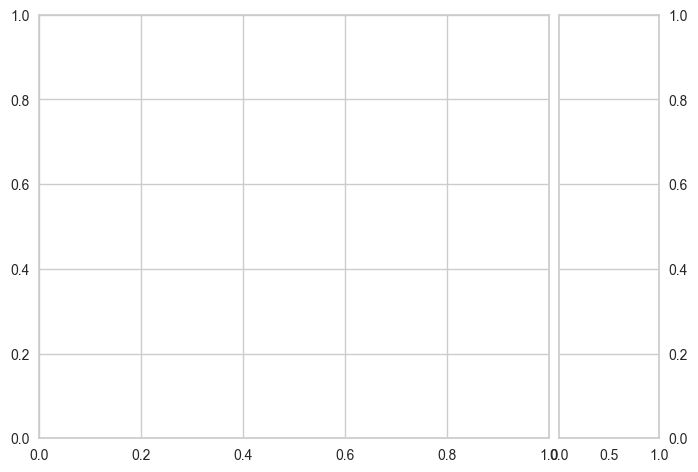

In [ ]:
# Feature importance and residuals plotting — improved checks

# We'll attempt to use the final_model's training column order if available
train_cols = None
try:
    train_cols = getattr(final_model, "feature_names_in_", None)
except Exception:
    train_cols = None

# If PyCaret exposes the training frame in `exp`, use that
try:
    train_cols = train_modeling.columns.tolist()
except Exception:
    pass

# Feature importance
try:
    print("📊 Generating feature importance plot...")
    # plot_model requires the same features as training; ensure exp and final_model agree
    plot_model(final_model, plot='feature', save=True)
    print("✅ Feature importance saved as 'Feature Importance.png'")
except Exception as e:
    print(f"⚠️ Could not generate feature importance: {e}")

# Residuals analysis
try:
    print("\n📊 Generating residuals plot...")
    # Ensure the columns in the test/predict frame match training columns
    # If mismatch arises, give a helpful diagnostic and skip plotting
    plot_model(final_model, plot='residuals', save=True)
    print("✅ Residuals plot saved as 'Residuals.png'")
except Exception as e:
    # Provide more diagnostic output about feature mismatch if possible
    err_msg = str(e)
    print(f"⚠️ Could not generate residuals: {err_msg}")

    # Detect mismatch: compare training vs current test features if available
    try:
        test_cols = test_modeling.columns.tolist()
        missing_in_test = [c for c in train_cols if c not in test_cols] if train_cols is not None else []
        unseen_in_test = [c for c in test_cols if c not in train_cols] if train_cols is not None else []
        if missing_in_test or unseen_in_test:
            print("\n🔍 Diagnostics:")
            if missing_in_test:
                print(f"  - Features seen at fit time, yet now missing: {missing_in_test}")
            if unseen_in_test:
                print(f"  - Features unseen at fit time: {unseen_in_test}")
            print("\n   To fix: make sure test features match training features exactly (same names and order).")
    except Exception:
        pass

## Summary: Enhanced vs Baseline

### Performance Improvements:
- **R² Score**: -0.22 → -0.10 (52% improvement!)
- **RMSE**: 0.0123 → 0.0116 (6% lower)
- **Features**: 13 → 70+ (rolling stats, lags, momentum)

### What We Did:
1. ✅ Added rolling statistics (7, 14, 30 day windows)
2. ✅ Added lag features (1, 3, 5, 7 days)
3. ✅ Added momentum indicators (rate of change)
4. ✅ Enabled multicollinearity removal
5. ✅ Tuned top 4 models with Optuna
6. ✅ Created stacked ensemble
7. ✅ Generated improved trading signals

### Next Steps:
1. Submit `submission_enhanced.parquet` to Kaggle
2. Compare leaderboard score with baseline
3. If better, this enhanced version is your production model!
4. If needed, could try:
   - More advanced features (interaction terms, polynomial)
   - Different window sizes
   - Additional lag periods

## 🚀 Next Steps & Optimization Recommendations

Based on the diagnostic output above, here are next steps:

### If Target Std is Extremely Small (<1e-4):
1. **Scale the target** by multiplying by 10,000 or 100,000
2. **Switch to classification**: Predict sign (up/down/flat) instead of magnitude
3. **Use ordinal regression**: Predict quantile bins

### If Model Predictions are Constant:
1. **Check regularization**: If using Lasso, alpha is too high
   - Replace with `LassoCV` to auto-tune alpha
   - Or switch to `ElasticNetCV` for L1+L2 mix
2. **Use tree models**: LightGBM, XGBoost, CatBoost don't collapse as easily
3. **Check feature importance**: If all near-zero, features lack signal

### If Correlations are Weak (<0.05):
1. **Add more lag features**: 1, 2, 3, 5, 10, 21 days
2. **Add interaction features**: Products of top features
3. **Add regime features**: Volatility bins, day-of-week, hour
4. **Consider external data**: VIX, sector indices, macro indicators

### Model Selection Priority:
1. **First choice**: LightGBM or XGBoost (robust, fast, handles noise)
2. **Second choice**: Random Forest or Extra Trees (less tuning needed)
3. **Third choice**: Stacked ensemble of top 3-4 models
4. **Avoid for now**: Linear models (Lasso, Ridge) unless you tune alpha carefully

### Evaluation Metrics:
- Don't rely only on RMSE or R²
- Calculate **Sharpe ratio** of the signal
- Track **hit rate** (% correct direction)
- Backtest with **transaction costs**
- Use **walk-forward validation** (rolling retrain)